<a href="https://colab.research.google.com/github/Himakar06/ipl-cricket-analysis/blob/main/notebooks/ipl_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
def load_data(path):
  return pd.read_csv(path)



In [38]:
#Cleaning match_data dataset
def clean_data(md,mid):

  extra = ['wides','noballs','byes','legbyes','penalty']
  md[extra] = md[extra].fillna(0).astype(int)

  md['wicket_type'] = md['wicket_type'].fillna('no dismissal')
  md['player_dismissed'] = md['player_dismissed'].fillna('none')
  md['other_player_dismissed'] = md['other_player_dismissed'].fillna('none')
  md['other_wicket_type'] = md['other_wicket_type'].fillna('no dismissal')

  mid['city'] = mid['city'].fillna('NA')
  mid['winner'] = mid['winner'].fillna('NA')
  mid['player_of_match'] =mid['player_of_match'].fillna('NA')
  mid['umpire3'] = mid['umpire3'].fillna('NA')

  md['start_date'] = pd.to_datetime(md['start_date'])
  mid['date'] = pd.to_datetime(mid['date'])

  return md,mid

In [40]:
#EDA

def eda(md, mid):
    req_team = input("Enter the team: ")
    sol = mid[(mid['team1'] == req_team) | (mid['team2'] == req_team)]
    match_counts = sol.groupby(sol['season']).size()
    print("\nSeason-wise Match Count:")
    print(match_counts)

    most_successful_teams = mid['winner'].value_counts().head(2)
    print(f"\nMost Successful Teams (Top 2):\n{most_successful_teams}")

    matches = mid[mid['winner'] != 'NA']
    for col in ['team1', 'team2', 'winner']:
        matches[col] = matches[col].str.strip()

    teams = pd.unique(matches[['team1', 'team2']].values.ravel()).tolist()
    print("\nBest Venue by Win Rate for Each Team:")
    for team in teams:
        team_matches = matches[(matches['team1'] == team) | (matches['team2'] == team)]
        team_wins = matches[matches['winner'] == team]
        venue_played = team_matches.groupby('venue').size()
        venue_wins = team_wins.groupby('venue').size()
        win_rate = ((venue_wins / venue_played) * 100).sort_values(ascending=False)
        if not win_rate.empty:
            best_venue = win_rate.head(1)
            print(f"\n{team} - Best Venue:")
            print(best_venue)

    both_wins = (matches['toss_winner'] == matches['winner']).sum()
    one_win = (matches['toss_winner'] != matches['winner']).sum()
    won_percentage = (both_wins / (both_wins + one_win)) * 100
    print(f"\nToss vs Match Win Percentage: {won_percentage:.2f}%")

    win_by_runs = (mid['win_by_runs'] > 0).sum()
    win_by_wickets = (mid['win_by_wickets'] > 0).sum()
    tie = ((mid['win_by_runs'] == 0) & (mid['win_by_wickets'] == 0)).sum()
    labels = ['Win by Runs', 'Win by Wickets', 'Tie']
    sizes = [win_by_runs, win_by_wickets, tie]
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%0.1f%%', startangle=90)
    plt.title('Match Result Types')
    plt.axis('equal')
    plt.show()

    runs = md.groupby(['season', 'striker'])['runs_off_bat'].sum().reset_index()
    seasonal_scorers = runs.sort_values(['season', 'runs_off_bat'], ascending=[True, False]).groupby('season').head(1)
    print("\nTop Run Scorer Each Season:")
    print(seasonal_scorers)

    batsman = md.groupby('striker')['runs_off_bat'].count()
    min_faced = batsman > 300
    strike_rate = (md.groupby('striker')['runs_off_bat'].sum() / batsman) * 100
    min_faced_batsman = strike_rate[min_faced].sort_values(ascending=False)
    print("\nTop Strike Rates (min 300 balls faced):")
    print(min_faced_batsman.head())

    md['total_runs'] = md['wides'] + md['runs_off_bat'] + md['noballs']
    runs_given = md.groupby('bowler')['total_runs'].sum()
    legal_balls = md[(md['wides'] == 0) & (md['noballs'] == 0)]
    balls_bowled = legal_balls.groupby('bowler').size()
    qualified_bowlers = balls_bowled[balls_bowled >= 300].index
    economy = ((runs_given[qualified_bowlers] / balls_bowled[qualified_bowlers]) * 6).sort_values()
    print("\nBest Bowling Economy (min 50 overs):")
    print(economy.head())

    wickets = md[md['wicket_type'].isin(['stumped', 'caught', 'lbw', 'caught and bowled', 'bowled', 'hit wicket'])]
    wickets_taken = wickets.groupby('bowler').size()
    best_figures = pd.concat([economy, wickets_taken], axis=1)
    best_figures.columns = ['economy', 'wickets_taken']
    best_figures = best_figures.sort_values('wickets_taken', ascending=False)
    print("\nBest Bowling Figures (by wickets taken):")
    print(best_figures.head())

    best_match_figures = (
        wickets.groupby(['match_id', 'bowler'])
        .size()
        .reset_index(name='wickets_in_match')
        .sort_values('wickets_in_match', ascending=False)
    )
    print("\nTop 10 Best Bowling Performances (in a single match):")
    print(best_match_figures.head(10))

    runs_per_match = md.groupby(['match_id', 'striker'])['runs_off_bat'].sum().reset_index()
    total_runs = runs_per_match.groupby('striker')['runs_off_bat'].sum().reset_index(name='total_runs')
    matches_played = runs_per_match.groupby('striker').size().reset_index(name='matches_played')
    batsman_stats = pd.merge(total_runs, matches_played, on='striker')
    batsman_stats['average_runs'] = batsman_stats['total_runs'] / batsman_stats['matches_played']

    balls_faced = md.groupby('striker')['runs_off_bat'].count().reset_index(name='balls_faced')
    batsman_stats = pd.merge(batsman_stats, balls_faced, on='striker')
    batsman_stats['strike_rate'] = (batsman_stats['total_runs'] / batsman_stats['balls_faced']) * 100

    fifties = runs_per_match[runs_per_match['runs_off_bat'] >= 50].groupby('striker').size().reset_index(name='fifties')
    batsman_stats = pd.merge(batsman_stats, fifties, on='striker', how='left')
    batsman_stats['fifties'] = batsman_stats['fifties'].fillna(0).astype(int)

    batsman_stats['consistency_score'] = (
        batsman_stats['average_runs'] * 0.5 +
        batsman_stats['strike_rate'] * 0.3 +
        batsman_stats['fifties'] * 2
    )
    top_consistent = batsman_stats.sort_values('consistency_score', ascending=False).head(10)
    print("\nMost Consistent Players:")
    print(top_consistent[['striker', 'average_runs', 'strike_rate', 'fifties', 'consistency_score']])

In [7]:
#Venue analysis: best win rate for each team

matches = mid[mid['winner'] != 'NA']

for col in ['team1','team2','winner']:
  matches[col] = matches[col].str.strip()

teams = pd.unique(matches[['team1','team2']].values.ravel()).tolist()
print(f"teams found: {teams}")
for team in teams:
  team_matches = matches[(matches['team1'] == team) | (matches['team2'] == team)]
  team_wins = matches[matches['winner'] == team]

  venue_played = team_matches.groupby('venue').size()
  venue_wins = team_wins.groupby('venue').size()

  win_rate = ((venue_wins/venue_played)*100).sort_values(ascending = False)

  if not win_rate.empty:
    best_venue = win_rate.head(1)
    print(f'\n{team} - best venue with win highest win ratio: ')
    print(best_venue)

teams found: ['Gujarat Titans', 'Chennai Super Kings', 'Mumbai Indians', 'Lucknow Super Giants', 'Sunrisers Hyderabad', 'Royal Challengers Bangalore', 'Kolkata Knight Riders', 'Delhi Capitals', 'Punjab Kings', 'Rajasthan Royals', 'Kings XI Punjab', 'Delhi Daredevils', 'Rising Pune Supergiant', 'Gujarat Lions', 'Rising Pune Supergiants', 'Pune Warriors', 'Deccan Chargers', 'Kochi Tuskers Kerala']

Gujarat Titans - best venue with win highest win ratio: 
venue
Arun Jaitley Stadium, Delhi    100.0
dtype: float64

Chennai Super Kings - best venue with win highest win ratio: 
venue
Brabourne Stadium    100.0
dtype: float64

Mumbai Indians - best venue with win highest win ratio: 
venue
Arun Jaitley Stadium, Delhi    100.0
dtype: float64

Lucknow Super Giants - best venue with win highest win ratio: 
venue
Sawai Mansingh Stadium, Jaipur    100.0
dtype: float64

Sunrisers Hyderabad - best venue with win highest win ratio: 
venue
Arun Jaitley Stadium    100.0
dtype: float64

Royal Challengers 

<ipython-input-7-2317249690>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches[col] = matches[col].str.strip()


In [41]:
def engineering_feature(md,mid):

  #Create match pressure
  mid.rename(columns = {'id' :'match_id'},inplace=True)
  first_innings = md[md['innings'] == 1].groupby('match_id')['total_runs'].sum().reset_index()
  first_innings.rename(columns={'total_runs': 'target_score'}, inplace=True)

  def get_chasing_team(row):
    if row['toss_decision'] == 'bat':
      return row['team2'] if row['toss_winner'] == row['team1'] else row['team1']
    else:
      return row['toss_winner']

  match_info = mid[['match_id', 'team1', 'team2', 'toss_winner', 'toss_decision']].copy()
  match_info['chasing_team'] = match_info.apply(get_chasing_team, axis=1)

  match_info = match_info[['match_id', 'chasing_team']]

  match_pressure_df = pd.merge(first_innings, match_info, on='match_id')

  def pressure_level(score):
    if score < 140:
      return 'Low'
    elif score < 170:
      return 'Medium'
    elif score < 200:
      return 'High'
    else:
      return 'Very High'

  match_pressure_df['match_pressure'] = match_pressure_df['target_score'].apply(pressure_level)

  print(match_pressure_df.head())



In [42]:
def preprocessing(md,mid):

  #One-hot encode team names

  for col in ['team1','team2','winner']:
    mid[col] = mid[col].str.strip()

  mid_encoded = pd.get_dummies(mid ,columns = ['team1','team2','winner'],drop_first = True)
  pd.set_option('display.max_columns',None)
  pd.set_option('display.width',800)
  print(mid_encoded.head())


loaded data
Match data 


<ipython-input-43-1360014011>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('match_data.csv')


,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,cricsheet_id
0,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.1,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
1,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.2,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
2,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.3,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
3,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.4,Gujarat Titans,Chennai Super Kings,Shubman Gill,WP Saha,DL Chahar,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
4,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.5,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353


Match info data


,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1370353,2023,Ahmedabad,2023/05/29,Gujarat Titans,Chennai Super Kings,Chennai Super Kings,field,D/L,1,Chennai Super Kings,0,5,DP Conway,"Narendra Modi Stadium, Ahmedabad",Nitin Menon,RJ Tucker,KN Ananthapadmanabhan
1,1370352,2023,Ahmedabad,2023/05/26,Gujarat Titans,Mumbai Indians,Mumbai Indians,field,normal,0,Gujarat Titans,62,0,Shubman Gill,"Narendra Modi Stadium, Ahmedabad",Nitin Menon,RJ Tucker,J Madanagopal
2,1370351,2023,Chennai,2023/05/24,Mumbai Indians,Lucknow Super Giants,Mumbai Indians,bat,normal,0,Mumbai Indians,81,0,Akash Madhwal,"MA Chidambaram Stadium, Chepauk, Chennai",BNJ Oxenford,VK Sharma,CB Gaffaney
3,1370350,2023,Chennai,2023/05/23,Chennai Super Kings,Gujarat Titans,Gujarat Titans,field,normal,0,Chennai Super Kings,15,0,RD Gaikwad,"MA Chidambaram Stadium, Chepauk, Chennai",AK Chaudhary,CB Gaffaney,BNJ Oxenford
4,1359543,2023,Mumbai,2023/05/21,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,8,C Green,"Wankhede Stadium, Mumbai",KN Ananthapadmanabhan,RJ Tucker,R Pandit


cleaned data
Match data 


,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,cricsheet_id
0,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.1,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,0,0,0,0,0,0,0,no dismissal,none,no dismissal,none,1370353
1,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.2,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,0,0,0,0,0,0,0,no dismissal,none,no dismissal,none,1370353
2,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.3,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,1,0,0,0,0,0,0,no dismissal,none,no dismissal,none,1370353
3,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.4,Gujarat Titans,Chennai Super Kings,Shubman Gill,WP Saha,DL Chahar,1,0,0,0,0,0,0,no dismissal,none,no dismissal,none,1370353
4,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.5,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,DL Chahar,1,0,0,0,0,0,0,no dismissal,none,no dismissal,none,1370353


Match info data


,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1370353,2023,Ahmedabad,2023-05-29,Gujarat Titans,Chennai Super Kings,Chennai Super Kings,field,D/L,1,Chennai Super Kings,0,5,DP Conway,"Narendra Modi Stadium, Ahmedabad",Nitin Menon,RJ Tucker,KN Ananthapadmanabhan
1,1370352,2023,Ahmedabad,2023-05-26,Gujarat Titans,Mumbai Indians,Mumbai Indians,field,normal,0,Gujarat Titans,62,0,Shubman Gill,"Narendra Modi Stadium, Ahmedabad",Nitin Menon,RJ Tucker,J Madanagopal
2,1370351,2023,Chennai,2023-05-24,Mumbai Indians,Lucknow Super Giants,Mumbai Indians,bat,normal,0,Mumbai Indians,81,0,Akash Madhwal,"MA Chidambaram Stadium, Chepauk, Chennai",BNJ Oxenford,VK Sharma,CB Gaffaney
3,1370350,2023,Chennai,2023-05-23,Chennai Super Kings,Gujarat Titans,Gujarat Titans,field,normal,0,Chennai Super Kings,15,0,RD Gaikwad,"MA Chidambaram Stadium, Chepauk, Chennai",AK Chaudhary,CB Gaffaney,BNJ Oxenford
4,1359543,2023,Mumbai,2023-05-21,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,8,C Green,"Wankhede Stadium, Mumbai",KN Ananthapadmanabhan,RJ Tucker,R Pandit


Enter the team: Chennai Super Kings

Season-wise Match Count:
season
2007/08    16
2009       14
2009/10    16
2011       16
2012       18
2013       18
2014       16
2015       17
2018       16
2019       17
2020/21    14
2021       16
2022       14
2023       16
dtype: int64

Most Successful Teams (Top 2):
winner
Mumbai Indians         138
Chennai Super Kings    131
Name: count, dtype: int64

Best Venue by Win Rate for Each Team:

Gujarat Titans - Best Venue:
venue
Arun Jaitley Stadium, Delhi    100.0
dtype: float64

Chennai Super Kings - Best Venue:
venue
Brabourne Stadium    100.0
dtype: float64

Mumbai Indians - Best Venue:
venue
Arun Jaitley Stadium, Delhi    100.0
dtype: float64

Lucknow Super Giants - Best Venue:
venue
Sawai Mansingh Stadium, Jaipur    100.0
dtype: float64

Sunrisers Hyderabad - Best Venue:
venue
Arun Jaitley Stadium    100.0
dtype: float64

Royal Challengers Bangalore - Best Venue:
venue
Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow    

<ipython-input-40-2611010722>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches[col] = matches[col].str.strip()


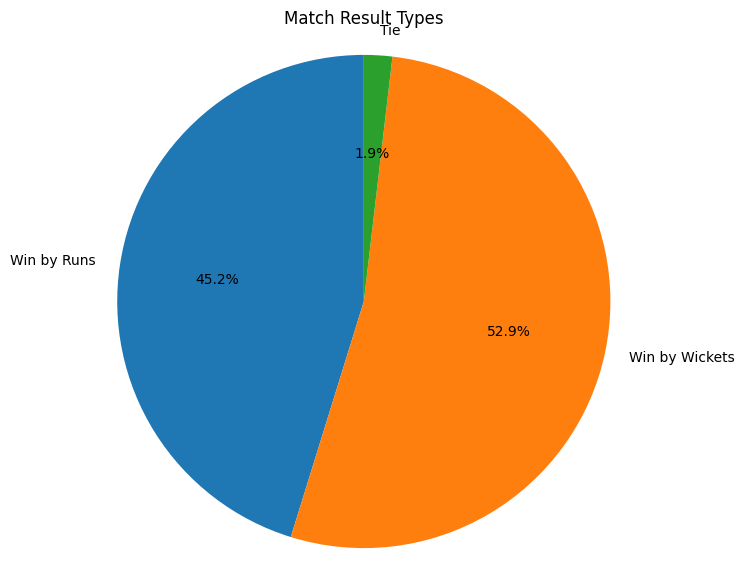


Top Run Scorer Each Season:
       season        striker  runs_off_bat
31       2011       CH Gayle           506
200      2012       CH Gayle           733
426      2013     MEK Hussey           733
604      2014     RV Uthappa           660
664      2015      DA Warner           562
899      2016        V Kohli           973
938      2017      DA Warner           641
1110     2018  KS Williamson           735
1209     2019      DA Warner           692
1373     2022     JC Buttler           728
1646     2023   Shubman Gill           890
1784  2007/08       SE Marsh           616
1898     2009      ML Hayden           572
2115  2009/10   SR Tendulkar           618
2209     2011    PC Valthaty           247
2292     2019      SR Watson           140
2350  2020/21       KL Rahul           676
2535     2021     RD Gaikwad           635
2607     2022   Ishan Kishan           135

Top Strike Rates (min 300 balls faced):
striker
AD Russell        164.919942
H Klaasen         160.625000
LS L

In [43]:
def main():
  md = pd.read_csv('match_data.csv')
  mid = pd.read_csv('match_info_data.csv')
  print("loaded data")
  print('Match data ')
  display(md.head())
  print('Match info data')
  display(mid.head())

  clean_data(md,mid)
  print("cleaned data")
  print('Match data ')
  display(md.head())
  print('Match info data')
  display(mid.head())

  eda(md,mid)

  engineering_feature(md,mid)

  preprocessing(md,mid)

if __name__ == "__main__":
  main()